In [1]:
from phoenix import sampling, actions_to_phase_space
from phoenix.potentials import miyamoto_nagai_potential, plummer_potential
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [2]:
params = {
    "R0": 8.0, # for actions to phase space
    "Rinit": 8.0, # for sampling
    "Rd": 2.5,
    "Sigma0": 100.0,
    "RsigR": 18.0,
    "RsigZ": 10.0,
    "sigmaR0_R0": 140.0,
    "sigmaz0_R0": 50.0,
    "L0": 1000.0,
    "Rinit_for_Rc": 8.0,
}

envelope_max = 3.0
n_candidates = 250_000
key = jax.random.PRNGKey(42)

Phi_disk = miyamoto_nagai_potential
theta_disk = jnp.array([1e12, 60.0, 0.01]) # (M, a, b) z.B. für Miyamoto-Nagai

In [3]:
#Generate candidate actions
from phoenix.distributionfunctions_disky_Binney import f_disc_from_params
candidates, samples, soft_weights = sampling.sample_df_potential(f_disc_from_params, key, params, Phi_disk, theta_disk, n_candidates, envelope_max, tau=0.01)
print("Number of candidate actions:", samples.shape[0])

#Map the candidate actions to phase-space coordinates
phase_space_coords = actions_to_phase_space.map_actions_to_phase_space(samples, params, key, Phi_disk, theta_disk)
x = phase_space_coords[:, 0]
y = phase_space_coords[:, 1]
z = phase_space_coords[:, 2]
v_x = phase_space_coords[:, 3]
v_y = phase_space_coords[:, 4]
v_z = phase_space_coords[:, 5]

/home/annalena/phoenix/phoenix/distributionfunctions_disky_Binney.py:13: UserWarning: As of jaxtyping version 0.2.24, jaxtyping now prefers the syntax
```
from jaxtyping import jaxtyped
# Use your favourite typechecker: usually one of the two lines below.
from typeguard import typechecked as typechecker
from beartype import beartype as typechecker

@jaxtyped(typechecker=typechecker)
def foo(...):
```
and the old double-decorator syntax
```
@jaxtyped
@typechecker
def foo(...):
```
should no longer be used. (It will continue to work as it did before, but the new approach will produce more readable error messages.)
In particular note that `typechecker` must be passed via keyword argument; the following is not valid:
```
@jaxtyped(typechecker)
def foo(...):
```

  @jaxtyped
/home/annalena/phoenix/phoenix/distributionfunctions_disky_Binney.py:37: UserWarning: As of jaxtyping version 0.2.24, jaxtyping now prefers the syntax
```
from jaxtyping import jaxtyped
# Use your favourite typechecker:

Number of candidate actions: 250000


In [4]:
import jax
import jax.numpy as jnp

def compute_density_jax(x, y, z, weights, r_bins, z_bins):
    # 1. Compute radial distance r
    r = jnp.sqrt(x**2 + y**2)

    # 2. Use histogram2d to accumulate weights efficiently
    # This replaces the entire fori_loop and digitize logic
    counts, _, _ = jnp.histogram2d(
        r, z, 
        bins=[r_bins, z_bins], 
        weights=weights
    )

    # 3. Compute the volume of each bin
    # Use midpoint r for volume calculation to be more accurate
    r_mid = (r_bins[:-1] + r_bins[1:]) / 2
    r_widths = jnp.diff(r_bins)
    z_widths = jnp.diff(z_bins)
    
    # Calculate volume of cylindrical shell: V = 2 * pi * r * dr * dz
    bin_volumes = 2 * jnp.pi * jnp.outer(r_mid * r_widths, z_widths)

    # 4. Normalize
    density = counts / bin_volumes
    
    return density

In [5]:
rbin = jnp.linspace(0, 10, 20)
zbin = jnp.linspace(-1, 1, 20)

In [6]:
density = compute_density_jax(x, y, z, soft_weights, r_bins=rbin, z_bins=zbin)

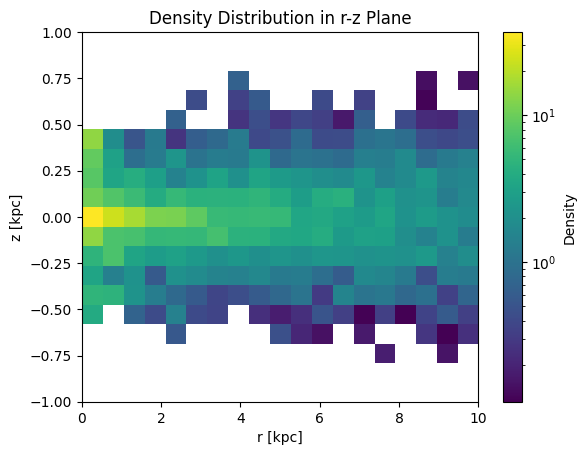

In [7]:
plt.imshow(density.T, origin='lower', aspect='auto',
           extent=[0, 10, -1, 1], cmap='viridis', norm=colors.LogNorm())
plt.colorbar(label='Density')
plt.xlabel('r [kpc]')
plt.ylabel('z [kpc]')
plt.title('Density Distribution in r-z Plane')
plt.show()

In [8]:
def compute_laplacian_on_grid(potential, theta, r_bins, z_bins):
    """
    Computes nabla^2 Phi (Laplacian) on the centers of the R-Z bins.
    """
    
    # 1. Define the Laplacian for a SINGLE point (x, y, z)
    def potential_wrapper(x, y, z):
        return potential(x, y, z, *theta)

    def laplacian_fn(x, y, z):
        # jax.hessian returns a 3x3 matrix of second derivatives
        # argnums=(0, 1, 2) makes it return a nested tuple structure relative to x,y,z
        # However, it's easier to treat input as a vector for Hessian logic,
        # but since our function takes scalars, we can just sum unmixed 2nd derivatives.
        
        # Method A: Direct curvature calculation (faster/simpler than full Hessian)
        # We use simple nested grad or specific derivative operators
        d2dx2 = jax.grad(lambda x_: jax.grad(potential_wrapper, argnums=0)(x_, y, z))(x)
        d2dy2 = jax.grad(lambda y_: jax.grad(potential_wrapper, argnums=1)(x, y_, z))(y)
        d2dz2 = jax.grad(lambda z_: jax.grad(potential_wrapper, argnums=2)(x, y, z_))(z)
        
        return d2dx2 + d2dy2 + d2dz2
    
    # 2. Vectorize the Laplacian function
    # Maps over inputs x, y, z
    laplacian_vmap = jax.vmap(laplacian_fn, in_axes=(0, 0, 0))

    # 3. Setup Grid (Bin Centers)
    r_centers = 0.5 * (r_bins[:-1] + r_bins[1:])
    z_centers = 0.5 * (z_bins[:-1] + z_bins[1:])
    
    # Create Meshgrid (indexing='ij' matches density shape)
    R_grid, Z_grid = jnp.meshgrid(r_centers, z_centers, indexing='ij')

    # 4. Convert R-Z to Cartesian X-Y-Z
    # We evaluate at y=0, so x=R
    X_flat = R_grid.flatten()
    Y_flat = jnp.zeros_like(X_flat)
    Z_flat = Z_grid.flatten()

    # 5. Compute
    laplacian_flat = laplacian_vmap(X_flat, Y_flat, Z_flat)
    
    # Reshape back to (N_r, N_z)
    laplacian_grid = laplacian_flat.reshape(R_grid.shape)
    
    return laplacian_grid

In [9]:

nabla2_Phi = compute_laplacian_on_grid(Phi_disk, theta_disk, rbin, zbin)

print("Laplacian shape:", nabla2_Phi.shape)

Laplacian shape: (19, 19)


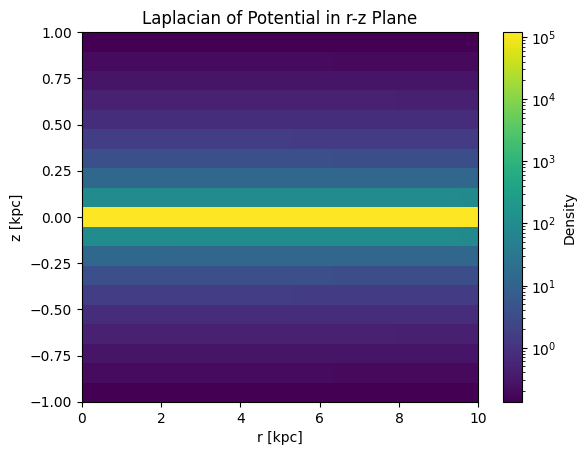

In [11]:
plt.imshow(nabla2_Phi.T, origin='lower', aspect='auto',
           extent=[0, 10, -1, 1], cmap='viridis', norm=colors.LogNorm())
plt.colorbar(label='Density')
plt.xlabel('r [kpc]')
plt.ylabel('z [kpc]')
plt.title('Laplacian of Potential in r-z Plane')
plt.show()

In [15]:
from phoenix.constants import G

def compute_loss(key, params, Phi_disk, theta_disk, n_candidates, envelope_max, rbin, zbin):
    candidates, samples, soft_weights = sampling.sample_df_potential(f_disc_from_params, key, params, Phi_disk, theta_disk, n_candidates, envelope_max, tau=0.01)
    phase_space_coords = actions_to_phase_space.map_actions_to_phase_space(samples, params, key, Phi_disk, theta_disk)
    x = phase_space_coords[:, 0]
    y = phase_space_coords[:, 1]
    z = phase_space_coords[:, 2]
    density = compute_density_jax(x, y, z, soft_weights, r_bins=rbin, z_bins=zbin)
    nabla2_Phi = compute_laplacian_on_grid(Phi_disk, theta_disk, r_bins=rbin, z_bins=zbin)
    lossplane = (4*jnp.pi*G*density - nabla2_Phi)*density/density

    return lossplane

In [16]:
lossplane = compute_loss(key, params, Phi_disk, theta_disk, n_candidates, envelope_max, rbin, zbin)

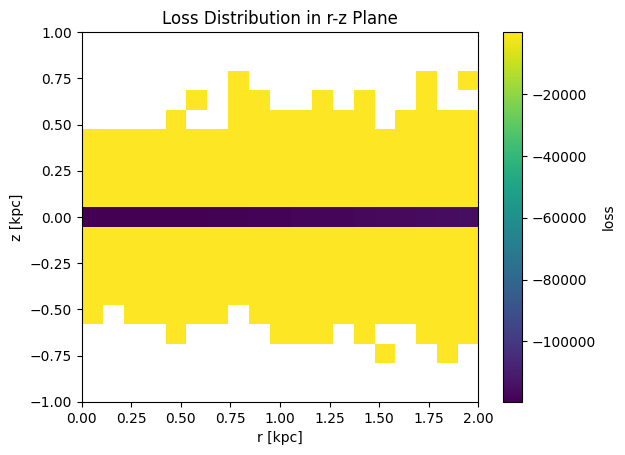

In [17]:
plt.imshow(lossplane.T, origin='lower', aspect='auto',
           extent=[0, 2, -1, 1], cmap='viridis')#, norm=colors.LogNorm())
plt.colorbar(label='loss')
plt.xlabel('r [kpc]')
plt.ylabel('z [kpc]')
plt.title('Loss Distribution in r-z Plane')
plt.show()